In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import librosa
import scipy.io.wavfile as wav
import os
import torchaudio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
root = "/kaggle/input/audio-mnist/data"
data = []
target = []
person = []

for i in range(1, 61):
    folderPath = os.path.join(root,str(i).zfill(2))
    files = os.listdir(folderPath)
    for file in files:
        tempPerson = ''
        temp = librosa.load(folderPath + '/' + file)
        temp = temp[0]
        target += file[0]
        person.append(int(i))
        data.append(temp)

In [5]:
class_names=sorted(pd.DataFrame(target)[0].unique().tolist())

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

paddedDataa = pad_sequences(data, padding='post', dtype='float32')

In [8]:
paddedDataa.shape

(30000, 22050)

In [9]:
target = [int(item) for item in target]

In [44]:
import torch
from torch.utils.data import Dataset
import scipy.io.wavfile as wav
import librosa
from torch.nn.functional import pad
from tensorflow.keras.preprocessing.sequence import pad_sequences


class AudioMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.ToSpectrogram = torchaudio.transforms.MelSpectrogram()
        self.ToDB = torchaudio.transforms.AmplitudeToDB()
        paddedDataa = pad_sequences(X, padding='post', dtype='float32')
        self.audio = paddedDataa
        self.labels = y
        assert(len(self.audio) == len(self.labels))
    
    def __len__(self):
        return len(self.audio)
    
    def padding(self, file):
        audio_padded = torch.zeros((1,25500))
        audio_padded[0,:len(file)] = torch.Tensor(file)
        return audio_padded
    
    def mfcc_data(self, file):
#         print(file)

        spectrogram = self.ToSpectrogram(file)
        spectrogram = self.ToDB(spectrogram)
        return spectrogram[0]
    
    def __getitem__(self, idx):
        padded = self.padding(self.audio[idx])
        audio_seq = self.mfcc_data(padded)
        label = self.labels[idx]
        audio_seq = audio_seq.unsqueeze(0)
        return audio_seq, label

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.15, random_state=42)

In [47]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(AudioMNISTDataset(X_train, y_train), batch_size=32)
test_loader = DataLoader(AudioMNISTDataset(X_test, y_test), batch_size=32)

In [48]:
for images, labels in train_loader:
    print(type(images))    
    print(images.shape)
    break


<class 'torch.Tensor'>
torch.Size([32, 1, 128, 128])


In [49]:
class MyCNN(nn.Module):
    
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3,padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*64*64,128)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(128,len(class_names))

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [53]:
model=MyCNN()
model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0005)

In [54]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

start_time = time.time()
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
train_correct=[]
best_model = None
best_model_loss = 100
num_epochs = 10
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    trn_corr = 0
    for batch_idx, (X_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X_train.to(device))
        loss = criterion(y_pred, y_train.to(device))
        loss.backward()
        optimizer.step()
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train.to(device)).sum()
        trn_corr += batch_corr

        if batch_idx % 200 == 0:
            print(f"Training Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.6f}")

    loss = loss.detach().cpu().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)

    model.eval()
    tst_corr = 0
    all_true = []
    all_pred = []

    with torch.no_grad():
        for batch_idx, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_val = model(X_test)
            loss = criterion(y_val, y_test)

            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr

            all_true.extend(y_test.cpu().numpy())
            all_pred.extend(predicted.cpu().numpy())

    test_loss = loss.item()
    test_acc = tst_corr.item() * 100 / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)
    # Compute and print F1 score, accuracy, precision, and recall
    f1 = f1_score(all_true, all_pred, average='weighted')
    acc = accuracy_score(all_true, all_pred)
    precision = precision_score(all_true, all_pred, average='weighted')
    recall = recall_score(all_true, all_pred, average='weighted')

    print(f"\nValidation/Test Loss: {test_loss:.6f}, Accuracy: {test_acc:.2f}%")
    print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")



Epoch 1/10
Training Batch 0/797 Loss: 3.771364
Training Batch 200/797 Loss: 0.116278
Training Batch 400/797 Loss: 0.064206
Training Batch 600/797 Loss: 0.007977

Validation/Test Loss: 0.301427, Accuracy: 97.93%
F1 Score: 0.9793, Precision: 0.9797, Recall: 0.9793

Epoch 2/10
Training Batch 0/797 Loss: 0.067569
Training Batch 200/797 Loss: 0.001142
Training Batch 400/797 Loss: 0.015608
Training Batch 600/797 Loss: 0.077288

Validation/Test Loss: 0.068996, Accuracy: 98.00%
F1 Score: 0.9800, Precision: 0.9803, Recall: 0.9800

Epoch 3/10
Training Batch 0/797 Loss: 0.038801
Training Batch 200/797 Loss: 0.002568
Training Batch 400/797 Loss: 0.003020
Training Batch 600/797 Loss: 0.000017

Validation/Test Loss: 0.022074, Accuracy: 98.56%
F1 Score: 0.9856, Precision: 0.9859, Recall: 0.9856

Epoch 4/10
Training Batch 0/797 Loss: 0.000541
Training Batch 200/797 Loss: 0.000580
Training Batch 400/797 Loss: 0.005486
Training Batch 600/797 Loss: 0.000105

Validation/Test Loss: 0.024721, Accuracy: 98.

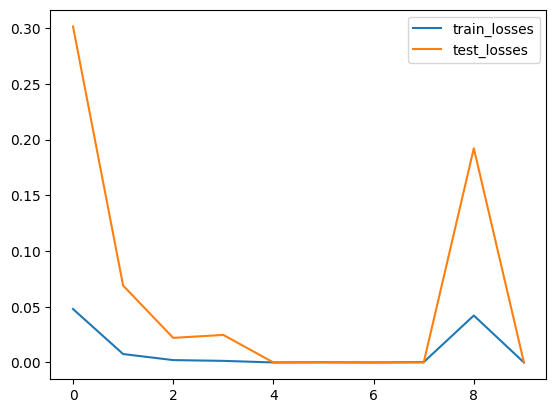

In [59]:
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()
plt.show()

In [55]:
model.eval()

y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(y_pred[0:5])

[7, 2, 8, 4, 6]


In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

           0     0.9978    0.9869    0.9923       457
           1     0.9956    0.9934    0.9945       456
           2     0.9979    0.9957    0.9968       470
           3     0.9931    0.9885    0.9908       434
           4     0.9955    0.9868    0.9911       453
           5     0.9828    0.9978    0.9902       457
           6     0.9977    0.9977    0.9977       442
           7     0.9712    0.9955    0.9832       441
           8     1.0000    0.9977    0.9989       438
           9     0.9978    0.9889    0.9933       452

    accuracy                         0.9929      4500
   macro avg     0.9929    0.9929    0.9929      4500
weighted avg     0.9930    0.9929    0.9929      4500



In [58]:
torch.save(model.state_dict(), 'CNN.pt')